In [1]:
import tskit
import numpy as np
import random
from tqdm.notebook import tqdm
import pandas as pd
import msprime
import matplotlib.pyplot as plt

In [2]:
from runsmc import liknb

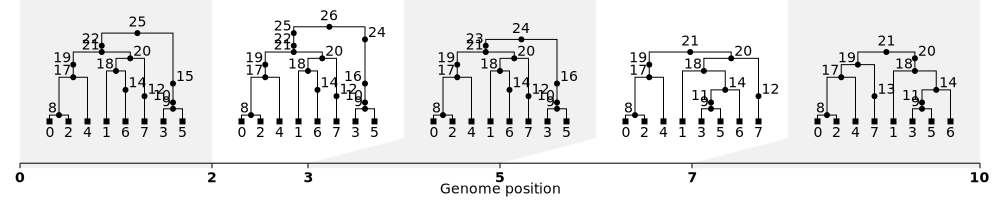

In [3]:
# Simple test example for polytomy making
ets = msprime.sim_ancestry(4, sequence_length=10, recombination_rate=0.05, record_full_arg=True, random_seed=12, model="smc")
ets.draw_svg(time_scale="rank")

Internal: 15	Del: 15


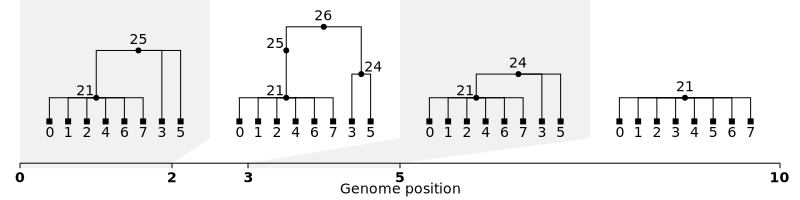

In [4]:
def naive_polytomy_maker(ts, del_nodes):
    del_nodes = set(del_nodes)
    assert len(set(ts.samples()) & del_nodes) == 0
    tables = ts.dump_tables()
    tables.edges.clear()
    for tree in ts.trees():
        assert tree.root not in del_nodes
        for node in tree.nodes():
            if node not in del_nodes:
                parent = tree.parent(node)
                while parent != tskit.NULL:
                    if parent not in del_nodes:
                        tables.edges.add_row(tree.interval.left, tree.interval.right, parent, node)
                        break
                    parent = tree.parent(parent)
    tables.sort()
    tables.edges.squash()
    tables.sort()
    return tables.tree_sequence()

def remove_internal_nodes(ts, fraction, rng):
    roots = set(tree.root for tree in ts.trees())
    #RE_nodes = np.where((ts.nodes_flags & msprime.NODE_IS_RE_EVENT) > 0)[0]
    #print(RE_nodes)
    # internal = set(range(ts.num_nodes)) - (set(RE_nodes) | roots | set(ts.samples()))
    # NOTE we originally kept the RE nodes, but it turns out that this places a strong
    # limit on how many polytomies we get because there's so much recombination. Removing
    # coalescent node doesn't creat a polytomy if there's a unary node on the branch
    # above it.
    internal = set(range(ts.num_nodes)) - (roots | set(ts.samples()))
    #print(internal)
    del_nodes = rng.sample(list(internal), int(len(internal) * fraction))
    print(f"Internal: {len(internal)}\tDel: {len(del_nodes)}")
    return naive_polytomy_maker(ts, del_nodes)

rng = random.Random(42)
tsp = remove_internal_nodes(ets, 1.0, rng)
#tsp = naive_polytomy_maker(ts, [11])
tsp.draw_svg(time_scale="rank")

In [5]:
def simplify_keeping_unary_in_coal(ts, map_nodes=False):
    """
    Keep the unary regions of nodes that are coalescent at least someone in the tree seq
    Temporary hack until https://github.com/tskit-dev/tskit/issues/2127 is addressed
    """
    tables = ts.dump_tables()
    # remove existing individuals. We will reinstate them later
    tables.individuals.clear()
    tables.nodes.individual = np.full_like(tables.nodes.individual, tskit.NULL)

    _, node_map = ts.simplify(map_nodes=True)
    keep_nodes = np.where(node_map != tskit.NULL)[0]
    # Add an individual for each coalescent node, so we can run
    # simplify(keep_unary_in_individuals=True) to leave the unary portions in.
    for u in keep_nodes:
        i = tables.individuals.add_row()
        tables.nodes[u] = tables.nodes[u].replace(individual=i)
    node_map = tables.simplify(keep_unary_in_individuals=True, filter_individuals=False)

    # Reinstate individuals
    tables.individuals.clear()
    for i in ts.individuals():
        tables.individuals.append(i)
    val, inverted_map = np.unique(node_map, return_index=True)
    inverted_map = inverted_map[val != tskit.NULL]
    tables.nodes.individual = ts.tables.nodes.individual[inverted_map]
    if map_nodes:
        return tables.tree_sequence(), node_map
    else:
        return tables.tree_sequence()

In [6]:
NE = 10000
MU = 1.25e-8
REC = 1.25e-8
SEQLEN = 1_000_000
seed = 4977
n = 100

full_arg = msprime.sim_ancestry(
        samples = n,
        record_full_arg=True,
        recombination_rate=REC,
        population_size=NE,
        sequence_length=SEQLEN,
        random_seed=seed,
        model='smc'
        )


In [7]:
full_arg

In [8]:
unary_coal =  simplify_keeping_unary_in_coal(full_arg)
unary_coal

In [9]:
fully_simplified = full_arg.simplify()
fully_simplified

In [49]:
inputs = {
    "full_arg_smc": full_arg,
    "unary_coal": unary_coal,
    "fully_simplified": fully_simplified
}
poly_inputs = {}

rng = random.Random(42)
for poly_frac in [0.05, 0.25, 0.5, 0.75]:
    for name, ts in inputs.items():  
        key = f"poly_{name}_{poly_frac}"
        print("start ", key)
        tsp = remove_internal_nodes(ts, poly_frac, rng)
        print(key, ts.num_edges, tsp.num_edges, sep="\t")
        poly_inputs[key] = tsp
        #dest[poly_fract] = tsp
    

start  poly_full_arg_smc_0.05
Internal: 8501	Del: 425
poly_full_arg_smc_0.05	13221	12788
start  poly_unary_coal_0.05
Internal: 2455	Del: 122
poly_unary_coal_0.05	6901	6812
start  poly_fully_simplified_0.05
Internal: 2455	Del: 122
poly_fully_simplified_0.05	10674	10673
start  poly_full_arg_smc_0.25
Internal: 8501	Del: 2125
poly_full_arg_smc_0.25	13221	11092
start  poly_unary_coal_0.25
Internal: 2455	Del: 613
poly_unary_coal_0.25	6901	6387
start  poly_fully_simplified_0.25
Internal: 2455	Del: 613
poly_fully_simplified_0.25	10674	11123
start  poly_full_arg_smc_0.5
Internal: 8501	Del: 4250
poly_full_arg_smc_0.5	13221	9079
start  poly_unary_coal_0.5
Internal: 2455	Del: 1227
poly_unary_coal_0.5	6901	6175
start  poly_fully_simplified_0.5
Internal: 2455	Del: 1227
poly_fully_simplified_0.5	10674	14980
start  poly_full_arg_smc_0.75
Internal: 8501	Del: 6375
poly_full_arg_smc_0.75	13221	7537
start  poly_unary_coal_0.75
Internal: 2455	Del: 1841
poly_unary_coal_0.75	6901	7192
start  poly_fully_simpl

In [50]:
poly_inputs

{'poly_full_arg_smc_0.05': <tskit.trees.TreeSequence at 0x7f182c3e6c20>,
 'poly_unary_coal_0.05': <tskit.trees.TreeSequence at 0x7f182c2986d0>,
 'poly_fully_simplified_0.05': <tskit.trees.TreeSequence at 0x7f182c3e7cd0>,
 'poly_full_arg_smc_0.25': <tskit.trees.TreeSequence at 0x7f182c3e6440>,
 'poly_unary_coal_0.25': <tskit.trees.TreeSequence at 0x7f182db2f220>,
 'poly_fully_simplified_0.25': <tskit.trees.TreeSequence at 0x7f182c3e60e0>,
 'poly_full_arg_smc_0.5': <tskit.trees.TreeSequence at 0x7f182c3e58a0>,
 'poly_unary_coal_0.5': <tskit.trees.TreeSequence at 0x7f182c3e4d30>,
 'poly_fully_simplified_0.5': <tskit.trees.TreeSequence at 0x7f182c3e4ac0>,
 'poly_full_arg_smc_0.75': <tskit.trees.TreeSequence at 0x7f182c3e53f0>,
 'poly_unary_coal_0.75': <tskit.trees.TreeSequence at 0x7f182c1633a0>,
 'poly_fully_simplified_0.75': <tskit.trees.TreeSequence at 0x7f182c163b50>}

# Running tsinfer on the input

In [51]:
import tsinfer
import tsdate

In [52]:
full_arg_muts = msprime.sim_mutations(full_arg, rate=MU, random_seed=42)
full_arg_muts

In [53]:
sd = tsinfer.SampleData.from_tree_sequence(full_arg_muts)

In [54]:
tsi_ts = tsinfer.infer(sd)

In [55]:
tsi_ts_dated = tsdate.date(tsi_ts, mutation_rate=MU, allow_unary=True)
tsi_ts_dated

In [56]:
tsi_ts_dated_fs = tsdate.date(tsi_ts.simplify(), mutation_rate=MU)
tsi_ts_dated_fs

In [57]:
inputs["tsinfer_tsdate"] = tsi_ts_dated
inputs["tsinfer_fs_tsdate"] = tsi_ts_dated_fs

# Polytomy statistics

In [58]:
poly_data = []
for key, ts in {**inputs, **poly_inputs}.items():
    #arity = np.zeros(ts.num_trees)
    #poly_count = np.zeros(ts.num_trees)
    leaves = np.zeros(ts.num_trees)
    unary = np.zeros(ts.num_trees)
    binary = np.zeros(ts.num_trees)
    poly = np.zeros(ts.num_trees)
    for tree in ts.trees():
        preorder = tree.preorder()
        num_children = tree.num_children_array[tree.preorder()]
        leaves[tree.index] = np.sum(num_children == 0)
        unary[tree.index] = np.sum(num_children == 1)
        binary[tree.index] = np.sum(num_children == 2)
        poly[tree.index] = np.sum(num_children > 2)
    # Note: means are slightly off here for tsinfer'd ones because the 
    # first and last trees are missing data
    poly_data.append({"name": key, "leaves": np.mean(leaves),
                      "unary": np.mean(unary),
                      "binary": np.mean(binary),
                      "poly": np.mean(poly)})
df_poly = pd.DataFrame(poly_data)
df_poly

,name,leaves,unary,binary,poly
0,full_arg_smc,200.0,1094.417661,199.000000,0.000000
1,unary_coal,200.0,456.396522,199.000000,0.000000
2,fully_simplified,200.0,0.000000,199.000000,0.000000
3,tsinfer_tsdate,200.0,181.260486,113.969095,36.562178
4,tsinfer_fs_tsdate,200.0,0.000000,113.975857,36.528816
5,poly_full_arg_smc_0.05,200.0,1025.565973,192.662462,3.153086
6,poly_unary_coal_0.05,200.0,429.315017,190.182253,4.372696
7,poly_fully_simplified_0.05,200.0,0.000000,185.691468,6.393174
8,poly_full_arg_smc_0.25,200.0,779.846233,176.830549,10.307876
9,poly_unary_coal_0.25,200.0,323.054926,154.422588,21.104016


# Likelihood surface for recombination rate

In [59]:
data = []
re_values = [REC] + list(np.logspace(-9, -7, num=40))

for rho in tqdm(re_values):
    ll = msprime.log_arg_likelihood(full_arg, rho, NE)
    datum = {"rho": rho, "full_arg_hudson": ll}
    for name, ts in {**inputs, **poly_inputs}.items():
        datum[name] = liknb.log_likelihood(ts, rho, NE)
    data.append(datum) 

  0%|          | 0/41 [00:00<?, ?it/s]

In [61]:
df = pd.DataFrame(data).set_index("rho")
df

,full_arg_hudson,full_arg_smc,unary_coal,fully_simplified,tsinfer_tsdate,tsinfer_fs_tsdate,poly_full_arg_smc_0.05,poly_unary_coal_0.05,poly_fully_simplified_0.05,poly_full_arg_smc_0.25,poly_unary_coal_0.25,poly_fully_simplified_0.25,poly_full_arg_smc_0.5,poly_unary_coal_0.5,poly_fully_simplified_0.5,poly_full_arg_smc_0.75,poly_unary_coal_0.75,poly_fully_simplified_0.75
rho,,,,,,,,,,,,,,,,,,
1.250000e-08,-221045.596568,-75650.465745,-71096.187298,-128242.982673,-81996.633098,-99961.631846,-74979.516718,-70319.919906,-129080.861724,-72761.439748,-66661.549420,-139343.775045,-70389.562774,-66406.177891,-220680.615448,-73850.206718,-87249.773719,-667012.534842
1.000000e-09,-225853.406385,-80539.250176,-75984.945246,-145469.504108,-87536.782324,-111270.376372,-79886.829235,-75270.849341,-146490.680027,-77775.402754,-71724.927942,-158409.606858,-75725.797899,-72128.395314,-248298.057712,-80228.194408,-95384.814879,-720526.240991
1.125336e-09,-225527.262510,-80212.223779,-75657.919138,-144565.655502,-87131.544998,-110613.943219,-79558.423703,-74939.976251,-145573.876679,-77439.858301,-71384.226667,-157389.543715,-75369.445267,-71742.661944,-246779.925753,-79797.190726,-94824.728947,-717428.052135
1.266380e-09,-225204.980958,-79888.949094,-75334.644777,-143665.559218,-86727.840379,-109962.376777,-79233.789426,-74612.890738,-144660.992738,-77108.167127,-71047.487128,-156374.384452,-75017.164669,-71361.432497,-245270.441775,-79371.247695,-94271.492010,-714352.584453
1.425103e-09,-224887.045816,-79569.896344,-75015.592393,-142769.685557,-86340.226965,-109316.287024,-78913.399075,-74290.067520,-143752.519446,-76780.812186,-70715.205870,-155364.743699,-74669.466476,-70985.271474,-243770.689678,-78950.999596,-93725.962489,-711302.685719
1.603719e-09,-224574.001843,-79255.594687,-74701.291147,-141878.563764,-85951.504378,-108676.360372,-78597.784566,-73972.040814,-142849.009613,-76458.336961,-70387.941675,-154361.313122,-74326.925025,-70614.814129,-242281.889215,-78537.160206,-93189.106398,-708281.560631
1.804722e-09,-224266.462077,-78946.639605,-74392.336528,-140992.789416,-85571.712765,-108043.369296,-78287.544481,-73659.411794,-141951.085338,-76141.353055,-70066.323359,-153364.871078,-73990.186640,-70250.775335,-240805.413013,-78130.532764,-92662.010827,-705292.815552
2.030918e-09,-223965.116392,-78643.701213,-74089.398657,-140113.032738,-85201.794058,-107418.183052,-77983.352428,-73352.856982,-141059.446689,-75830.548725,-69751.058553,-152376.293478,-73659.978651,-69893.959567,-239342.805742,-77732.021184,-92145.899116,-702340.508847
2.285464e-09,-223670.741125,-78347.533617,-73793.231647,-139240.047960,-84842.731765,-106801.779875,-77685.966439,-73053.137692,-140174.881479,-75526.698493,-69442.943576,-151396.566017,-73337.119550,-69545.272124,-237895.805672,-77342.642672,-91642.147933,-699429.207542


In [62]:
df.to_csv("likelihood_surface.csv")